<a href="https://colab.research.google.com/github/KOISSYK/dacon/blob/main/%EC%98%81%ED%99%94%EA%B4%80%EA%B0%9D%EC%88%98%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dacon 영화관객수 예측



In [208]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

title : 영화의 제목

distributor : 배급사

genre : 장르

release_time : 개봉일

time : 상영시간(분)

screening_rat : 상영등급

director : 감독이름

dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 
관객수가 알려지지 않은 영화 제외)

dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 
알려지지 않은 영화 제외)

num_staff : 스텝수

num_actor : 주연배우수

box_off_num : 관객수


# 1.문제유형 및 데이터 정리

## 1.1 패키지로드

In [209]:
from numpy.lib.function_base import select
import os
import sys

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer





## 1.2 파일로드

In [210]:
df_train = pd.read_csv('movies_train.csv')
df_test = pd.read_csv('movies_test.csv')
df_sub = pd.read_csv('submission.csv')

# 2.전처리

## 2.1 데이터 확인 분석

In [211]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [212]:
df_train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [213]:
df_test.head(10)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1
5,회오리 바람,모쿠슈라,드라마,2010-02-25,95,15세 관람가,장건재,NaN,0,156,2
6,경계도시 2,시네마 달,다큐멘터리,2010-03-18,104,15세 관람가,홍형숙,NaN,0,11,2
7,이웃집 남자,(주)루믹스미디어,드라마,2010-03-18,100,청소년 관람불가,장동홍,NaN,0,117,5
8,아마존의 눈물 극장판,마운틴픽쳐스,다큐멘터리,2010-03-25,88,15세 관람가,김진만,NaN,0,76,1
9,반가운 살인자,롯데쇼핑(주)롯데엔터테인먼트,코미디,2010-04-08,107,15세 관람가,김동욱,NaN,0,255,3


In [214]:
df_train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [215]:
df_test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64



*   train, test set 결측치확인(dir_prev_bfnum)


In [216]:
df_train.shape

(600, 12)

In [217]:
df_train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [218]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


## 2.2 컬럼 삭제

In [219]:
df_train.drop(['title'],inplace = True, axis = 1)
df_test.drop(['title'],inplace = True, axis = 1)

## 2.3 dir_prev_bfnum

### 2.3.1결측치 확인 

In [220]:
df_train[df_train['dir_prev_bfnum'].isna() == 1] #(dir_prev_bfnum)에 대한 결측치 확인 

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
6,백두대간,다큐멘터리,2013-05-23,104,전체 관람가,이창재,NaN,0,32,5,53526
8,유니버설픽쳐스인터내셔널코리아,뮤지컬,2014-09-18,129,전체 관람가,정성복,NaN,0,3,5,4778
9,(주)두타연,드라마,2012-03-15,94,15세 관람가,변성현,NaN,0,138,3,868
10,(주) 케이알씨지,멜로/로맨스,2015-07-27,89,청소년 관람불가,조조 히데오,NaN,0,0,4,745
...,...,...,...,...,...,...,...,...,...,...,...
593,퍼스트런,미스터리,2013-09-12,97,청소년 관람불가,최위안,NaN,0,5,3,1132
594,(주)마운틴픽쳐스,코미디,2014-03-20,94,청소년 관람불가,노진수,NaN,0,37,5,1958
597,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


dir_prev_bfnum 의 nan값은 대체값을 넣어 계산하기에는 결측치가 너무 많아 제거하는게 낫다고 생각했으나 결측치값들은 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수가 0일떄 이다.
결측치의 값을 0으로 해주면될거같다.

### 2.3.2 결측치 대체

In [221]:
df_train['dir_prev_bfnum'].fillna(0, inplace = True)
df_test['dir_prev_bfnum'].fillna(0, inplace = True)

In [222]:
df_train.head()

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398
1,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


### 2.3.3 결측치가 잘 처리 되었는지 확인

In [223]:
df_train.isnull().sum()
df_test.isnull().sum()

distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64

## 2.4 distributor(배급사)

In [224]:
df_train['distributor'].unique()

array(['롯데엔터테인먼트', '(주)쇼박스', '(주)NEW', '쇼박스(주)미디어플렉스', '백두대간',
       '유니버설픽쳐스인터내셔널코리아', '(주)두타연', '(주) 케이알씨지', '(주)콘텐츠 윙', '(주)키노아이',
       '(주)팝 파트너스', 'CJ E&M 영화부문', '(주) 영화제작전원사', 'CJ E&M Pictures',
       'CGV 무비꼴라쥬', '리틀빅픽처스', '스폰지', 'CJ 엔터테인먼트', 'CGV아트하우스', '조이앤시네마',
       '인디플러그', '콘텐츠판다', '인디스토리', '(주)팝엔터테인먼트', '시네마서비스', '웃기씨네',
       '영화사 진진', '(주)레인보우 팩토리', '김기덕 필름', 'NEW', 'CJ CGV',
       '동국대학교 충무로영상제작센터', 'BoXoo 엔터테인먼트', '(주)마운틴픽쳐스', 'CGV 아트하우스',
       '메가박스(주)플러스엠', '골든타이드픽처스', '파이오니아21', '디 씨드', '드림팩트 엔터테인먼트', '시너지',
       '디마엔터테인먼트', '판다미디어', '(주)스톰픽쳐스코리아', '(주)예지림 엔터테인먼트', '(주) 영화사조제',
       '보람엔터테인먼트', '(주)시네마달', '노바엔터테인먼트', '(주)패스파인더씨앤씨', '(주)대명문화공장',
       '(주)온비즈넷', 'KT&G 상상마당', '무비꼴라쥬', '인벤트 디', '씨네그루(주)키다리이엔티',
       '스튜디오후크', '시네마 달', '나이너스엔터테인먼트(주)', 'THE 픽쳐스', '영구아트무비', '리틀빅픽쳐스',
       '어뮤즈', '이모션 픽처스', '(주)이스트스카이필름', '필라멘트 픽쳐스', '조이앤컨텐츠그룹', '타임스토리그룹',
       '마운틴 픽처스', '(주)휘엔터테인먼트', '이십세기폭스코리아(주)', '(주)피터팬픽쳐스', '에스와이코마드',
       '(주)더픽쳐스', '오퍼스픽쳐스'

In [225]:
df_train[["distributor", "box_off_num"]].groupby("distributor").mean().sort_values("box_off_num")

,box_off_num
distributor,
인피니티엔터테인먼트,2.000000e+00
고구마공작소,8.000000e+00
사람과 사람들,4.200000e+01
위드시네마,4.600000e+01
나우콘텐츠,5.400000e+01
...,...
영구아트무비,2.541603e+06
쇼박스(주)미디어플렉스,2.634823e+06
(주)아이필름코퍼레이션,3.117859e+06


### 2.4.1 배급사데이터 중복 확인

In [226]:
dist_common = list(set(df_train['distributor']) & set(df_test['distributor']))
print(len(dist_common))
# & 연산자를 사용하여 둘다 있을떄를 True로 하고 출력

# train에만 존재하는 배급사 확인
dist_only_train = list(set(df_train['distributor']) - set(df_test['distributor']))
print(len(dist_only_train))

# test에만 존재하는 배급사 확인
dist_only_test = list(set(df_test['distributor']) - set(df_train['distributor']))
print(len(dist_only_test))

58
111
35


In [227]:
df_train["distributor"].value_counts()

CJ 엔터테인먼트        54
롯데엔터테인먼트         52
(주)NEW           30
(주)마운틴픽쳐스        29
(주)쇼박스           26
                 ..
OAL(올)            1
(주)에이원 엔터테인먼트     1
(주)콘텐츠 윙          1
위더스필름             1
퍼스트런              1
Name: distributor, Length: 169, dtype: int64

### 2.4.2 배급사 중복 처리

#### 2.4.2.1 겹치지않는 배급사 정렬

In [228]:
dist_seem = set(df_train['distributor']) - set(dist_common)
a = list(dist_seem)
print(len(dist_seem))
a.sort()
print(a)

111
['(주) 브릿지웍스', '(주)JK필름', '(주)고앤고 필름', '(주)대명문화공장', '(주)더픽쳐스', '(주)드림팩트엔터테인먼트', '(주)랠리버튼', '(주)레인보우 팩토리', '(주)로드하우스', '(주)리틀빅픽처스', '(주)마인스엔터테인먼트', '(주)스마일이엔티', '(주)시네마달', '(주)씨엠닉스', '(주)아우라픽처스', '(주)아이필름코퍼레이션', '(주)온비즈넷', '(주)유비네트워크', '(주)유비콘텐츠', '(주)이스트스카이필름', '(주)콘텐츠 윙', '(주)팝 파트너스', '(주)패뷸러스', '(주)패스파인더씨앤씨', '(주)프레인글로벌', '(주)피터팬픽쳐스', '(주)휘엔터테인먼트', 'CGV 무비꼴라쥬', 'CGV 아트하우스', 'CJ CGV', 'CJ E&M 영화부문', 'KBS미디어(주)', 'KT', 'M2픽처스', 'OAL(올)', 'SK텔레콤(주)', 'SK플래닛', 'THE 픽쳐스', 'tvN', 'ysfilm', '건시네마', '고구마공작소', '김기덕 필름', '나우콘텐츠', '더 피플', '더픽쳐스/(주)마운틴픽쳐스', '동국대학교 충무로영상제작센터', '두 엔터테인먼트', '드림팩트 엔터테인먼트', '디 씨드', '디마엔터테인먼트', '롤러코스터 프로덕션', '리틀빅픽쳐스', '마노엔터테인먼트', '마법사필름', '마운틴 픽처스', '머스트 씨 무비', '미라클 필름', '백두대간', '보람엔터테인먼트', '사람과 사람들', '상구네 필름', '새인컴퍼니', '서울독립영화제', '스크린조이', '스튜디오 느림보', '스튜디오 블루', '스튜디오후크', '스폰지', '싸이더스 FNH', '싸이더스FNH', '아방가르드 필름', '어썸 피플', '에스와이코마드', '에스피엠', '에이블엔터테인먼트', '영구아트무비', '영화사 廊', '영화사 조아', '영희야놀자', '와이드 릴리즈(주)', '와이드릴리즈(주)', '위더스필름', '유니버설픽쳐스인터내셔널코리아', '이달투', '이모션 픽처스', '이

#### 2.4.2.2 배급사명의 있는 (주) 빼기

In [229]:
import re
df_train['distributor'] = df_train.distributor.str.replace('(주)', ' ')
df_train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in df_train.distributor]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [230]:
df_test['distributor'] = df_test.distributor.str.replace('(주)', ' ')
df_test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in df_test.distributor]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [231]:
df_train["distributor"]

0       롯데엔터테인먼트
1            쇼박스
2            쇼박스
3            NEW
4      쇼박스미디어플렉스
         ...    
595          NEW
596          쇼박스
597       마운틴픽쳐스
598     CJ엔터테인먼트
599     CJ엔터테인먼트
Name: distributor, Length: 600, dtype: object

#### 2.4.2.3 유사한 회사 하나로 묶기

In [232]:
def get_dist(x):
      if 'CJ' in x or 'CGV' in x or 'tvn' in x :
        return 'CJ'
      elif 'KT' in x:
        return 'KT'
      elif 'SK' in x:
        return 'SK'
      elif 'THE픽쳐스'in x or '더픽쳐스' in x:
        return '픽쳐스'
      elif '스폰지' in x :
        return '스폰지'
      elif '싸이더스' in x :
        return '싸이더스'
      elif '드림팩트' in x :
        return '드림팩트'
      elif '마운틴' in x:
        return '마운틴'
      elif '메가박스' in x:
        return '메가박스'
      elif '쇼박스' in x:
        return '쇼박스'
      elif '조이' in x:
        return '조이'
      elif '키노' in x:
        return '키노'
      else : 
        return x

In [233]:
df_train['distributor'] = df_train.distributor.apply(get_dist)
df_test['distributor'] = df_test.distributor.apply(get_dist)

In [234]:
df_train['distributor'].tail(20)

580           CJ
581        인디플러그
582          NEW
583    마인스엔터테인먼트
584          시너지
585        인디플러그
586     마노엔터테인먼트
587        영화사조제
588           CJ
589          쇼박스
590           CJ
591    씨너스엔터테인먼트
592           CJ
593         퍼스트런
594          마운틴
595          NEW
596          쇼박스
597          마운틴
598           CJ
599           CJ
Name: distributor, dtype: object

In [235]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     243 non-null    object 
 1   genre           243 non-null    object 
 2   release_time    243 non-null    object 
 3   time            243 non-null    int64  
 4   screening_rat   243 non-null    object 
 5   director        243 non-null    object 
 6   dir_prev_bfnum  243 non-null    float64
 7   dir_prev_num    243 non-null    int64  
 8   num_staff       243 non-null    int64  
 9   num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 19.1+ KB


#### 2.4.2.4배급사별 영화 관객수 중위값 기준으로 배급사 랭크 인코딩

In [236]:
df_train.groupby('distributor').box_off_num.mean().sort_values()

distributor
인피니티엔터테인먼트    2.000000e+00
고구마공작소        8.000000e+00
사람과사람들        4.200000e+01
위드시네마         4.600000e+01
나우콘텐츠         5.400000e+01
                  ...     
NEW           1.939060e+06
CJ            2.066506e+06
영구아트무비        2.541603e+06
아이필름코퍼레이션     3.117859e+06
쇼박스           3.332954e+06
Name: box_off_num, Length: 143, dtype: float64

In [237]:
tr_nm_rank = df_train.groupby('distributor').box_off_num.median().reset_index(name = 'dist_num_rank').sort_values(by = 'dist_num_rank')
tr_nm_rank   

,distributor,dist_num_rank
107,인피니티엔터테인먼트,2.0
13,고구마공작소,8.0
50,사람과사람들,42.0
94,위드시네마,46.0
17,나우콘텐츠,54.0
...,...,...
110,전망좋은영화사,1214237.0
102,이십세기폭스코리아,1422844.0
54,쇼박스,2138560.0
81,영구아트무비,2541603.0


In [238]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     243 non-null    object 
 1   genre           243 non-null    object 
 2   release_time    243 non-null    object 
 3   time            243 non-null    int64  
 4   screening_rat   243 non-null    object 
 5   director        243 non-null    object 
 6   dir_prev_bfnum  243 non-null    float64
 7   dir_prev_num    243 non-null    int64  
 8   num_staff       243 non-null    int64  
 9   num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 19.1+ KB


In [239]:
tr_nm_rank['dist_num_rank'] = [i + 1 for i in range(tr_nm_rank.shape[0])]

In [240]:
df_train = pd.merge(df_train, tr_nm_rank,how = 'left')
df_test = pd.merge(df_test, tr_nm_rank, how = 'left')

In [241]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     243 non-null    object 
 1   genre           243 non-null    object 
 2   release_time    243 non-null    object 
 3   time            243 non-null    int64  
 4   screening_rat   243 non-null    object 
 5   director        243 non-null    object 
 6   dir_prev_bfnum  243 non-null    float64
 7   dir_prev_num    243 non-null    int64  
 8   num_staff       243 non-null    int64  
 9   num_actor       243 non-null    int64  
 10  dist_num_rank   212 non-null    float64
dtypes: float64(2), int64(4), object(5)
memory usage: 22.8+ KB


학습도중 test와 submission 에 인덱스개수가 일치하지 않는 것을 발견하고 결측치를 0으로 채움

In [242]:
df_test.fillna(0, inplace = True) 

In [243]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     243 non-null    object 
 1   genre           243 non-null    object 
 2   release_time    243 non-null    object 
 3   time            243 non-null    int64  
 4   screening_rat   243 non-null    object 
 5   director        243 non-null    object 
 6   dir_prev_bfnum  243 non-null    float64
 7   dir_prev_num    243 non-null    int64  
 8   num_staff       243 non-null    int64  
 9   num_actor       243 non-null    int64  
 10  dist_num_rank   243 non-null    float64
dtypes: float64(2), int64(4), object(5)
memory usage: 22.8+ KB


In [244]:
df_train['dist_num_rank']

0      130
1      141
2      141
3      136
4      141
      ... 
595    136
596    141
597     45
598    137
599    137
Name: dist_num_rank, Length: 600, dtype: int64

In [245]:
df_test['dist_num_rank']

0      128.0
1      141.0
2      137.0
3      141.0
4      137.0
       ...  
238    109.0
239     67.0
240      0.0
241     45.0
242     28.0
Name: dist_num_rank, Length: 243, dtype: float64

### 2.4.5 distributor 제거

In [246]:
df_train.drop(['distributor'],inplace = True, axis = 1)
df_test.drop(['distributor'],inplace = True, axis = 1)

## 2.5 genre

In [247]:
df_train['genre'].unique()

array(['액션', '느와르', '코미디', '다큐멘터리', '뮤지컬', '드라마', '멜로/로맨스', '공포', '서스펜스',
       '애니메이션', '미스터리', 'SF'], dtype=object)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49496 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50752 missing from current font.
  font.set_

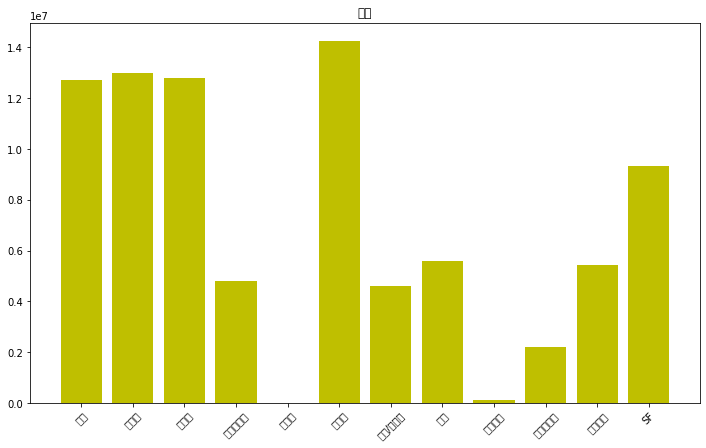

In [248]:
plt.figure(figsize = (12,7))
plt.bar(df_train['genre'],df_train['box_off_num'],color = 'y')
plt.xticks(rotation = 45)
plt.title('장르')
plt.rc('font', family='NanumBarunGothic')
plt.show()
plt.close()

In [249]:
df_train.groupby('genre').box_off_num.mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

### 2.5.1 장르 인코딩

In [250]:
df_train['genre_rank'] = df_train.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
df_test['genre_rank'] = df_test.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

### 2.5.2 genre컬럼 제거

In [251]:
df_train.drop(['genre'],inplace = True, axis = 1)
df_test.drop(['genre'],inplace = True, axis = 1)

## 2.6 release_time


In [252]:
df_train['release_time'].unique()

array(['2012-11-22', '2015-11-19', '2013-06-05', '2012-07-12',
       '2010-11-04', '2012-10-25', '2013-05-23', '2012-10-11',
       '2014-09-18', '2012-03-15', '2015-07-27', '2015-07-30',
       '2012-03-22', '2013-09-25', '2014-09-04', '2011-05-04',
       '2012-04-05', '2014-11-13', '2010-05-05', '2014-09-03',
       '2015-08-13', '2014-02-13', '2014-11-27', '2015-09-10',
       '2010-02-18', '2010-03-18', '2013-08-29', '2011-03-24',
       '2011-07-07', '2015-04-30', '2011-12-08', '2011-12-01',
       '2015-06-04', '2014-07-03', '2014-05-22', '2012-02-29',
       '2010-03-25', '2013-04-04', '2010-04-22', '2014-03-27',
       '2010-10-28', '2013-05-30', '2010-01-14', '2015-12-03',
       '2014-11-26', '2014-08-07', '2014-10-16', '2015-01-07',
       '2010-07-29', '2014-10-02', '2012-01-05', '2015-05-21',
       '2015-04-23', '2010-07-01', '2013-11-14', '2014-12-31',
       '2013-11-21', '2012-05-10', '2012-09-20', '2014-07-09',
       '2015-11-25', '2011-09-29', '2015-01-29', '2015-

In [253]:
df_train.drop(['release_time'],inplace = True, axis = 1)
df_test.drop(['release_time'],inplace = True, axis = 1)

## 2.7 screening_rat

In [254]:
df_train['screening_rat'].unique()

array(['청소년 관람불가', '15세 관람가', '전체 관람가', '12세 관람가'], dtype=object)

### 2.7.1 screenig_rat 시각화

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48520 missing from current font.
  font.set_

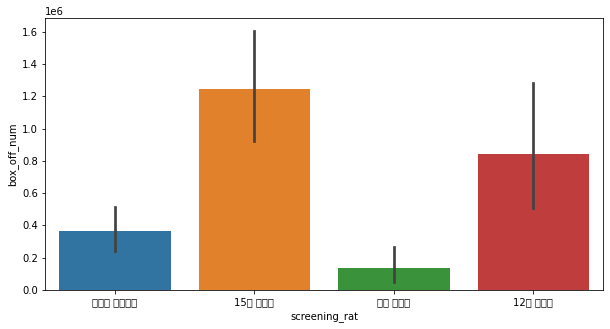

In [255]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_train, x="screening_rat", y="box_off_num")

15세관람가와 12세 관람가가 다른 2개보다 높은 수치를 나타내고 있음.

상영가능나이대도 관객수에 영향을 준다.

### 2.7.2 screening_rat 랭크인코딩 (중위값)

In [256]:
tr_scre_nm_rank = df_train.groupby('screening_rat').box_off_num.median().reset_index(name = 'scre_num_rank').sort_values(by = 'scre_num_rank')
tr_scre_nm_rank

,screening_rat,scre_num_rank
3,청소년 관람불가,3008.5
2,전체 관람가,8325.0
0,12세 관람가,19323.0
1,15세 관람가,242381.0


In [257]:
tr_scre_nm_rank

,screening_rat,scre_num_rank
3,청소년 관람불가,3008.5
2,전체 관람가,8325.0
0,12세 관람가,19323.0
1,15세 관람가,242381.0


In [258]:
df_train

,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dist_num_rank,genre_rank
0,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,130,11
1,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,141,12
2,123,15세 관람가,장철수,220775.25,4,343,4,6959083,141,11
3,101,전체 관람가,구자홍,23894.00,2,20,6,217866,136,9
4,108,15세 관람가,신근호,1.00,1,251,2,483387,141,9
...,...,...,...,...,...,...,...,...,...,...
595,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091,136,8
596,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438,141,8
597,99,청소년 관람불가,김대현,0.00,0,123,4,2475,45,7
598,102,15세 관람가,백운학,0.00,0,431,4,2192525,137,12


* 원핫인코딩

In [259]:
tr_scre_nm_rank['scre_nm_rank'] = [i + 1 for i in range(tr_scre_nm_rank.shape[0])]
tr_scre_nm_rank

,screening_rat,scre_num_rank,scre_nm_rank
3,청소년 관람불가,3008.5,1
2,전체 관람가,8325.0,2
0,12세 관람가,19323.0,3
1,15세 관람가,242381.0,4


In [260]:
df_train = pd.merge(df_train, tr_scre_nm_rank)
df_test = pd.merge(df_test, tr_scre_nm_rank)

In [261]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            243 non-null    int64  
 1   screening_rat   243 non-null    object 
 2   director        243 non-null    object 
 3   dir_prev_bfnum  243 non-null    float64
 4   dir_prev_num    243 non-null    int64  
 5   num_staff       243 non-null    int64  
 6   num_actor       243 non-null    int64  
 7   dist_num_rank   243 non-null    float64
 8   genre_rank      243 non-null    int64  
 9   scre_num_rank   243 non-null    float64
 10  scre_nm_rank    243 non-null    int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 22.8+ KB


In [262]:
df_train.drop(['screening_rat'],inplace = True, axis = 1)
df_test.drop(['screening_rat'],inplace = True, axis = 1)

## 2.8 dir_prev_num

In [263]:
df_train['dir_prev_num'].unique()

array([0, 2, 3, 1, 4, 5])

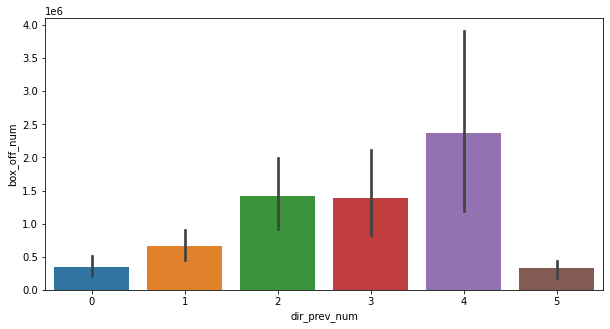

In [264]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_train, x="dir_prev_num", y="box_off_num")

그래프를 보기 전에는 당연히 5개를 만들 감독들의 수치가 높을 것이라 예상했지만 꼭 그렇지만도 않았다. 


## 2.9 director

In [265]:
df_train['director'].unique()

array(['조병옥', '우민호', '임상윤', '조조 히데오', '한종훈', '홍상수', '안국진', '권칠인', '김재한',
       '손승웅', '김철한', '한상희', '김조광수', '김기덕', '민규동', '진승현', '도창훈', '류승완',
       '전수일', '하기호', '정범식', '남기웅', '곽경택', '이지형', '김인식', '이영미', '이정범',
       '박재식', '김상만', '정연식', '한동호', '손영국', '김동명', '김대우', '방현준', '연상호',
       '전재홍', '신재영', '조근현', '윤종빈', '김병준', '허은희', '고석진', '하마구치 류스케', '조원희',
       '박형우', '이수성', '박헌수', '이현철', '장성수', '조창호', '박석영', '김회근', '박선욱',
       '신재호', '주경중', '장건재', '박상현', '신혜성', 'New Pistol', '한윤선', '유하',
       '임상수', '강우석', '노진수', '권형진', '박철수', '김동후', '오영두', '이상우', '황철민',
       '김명서', '황욱', '정용택', '지하진', '문정윤', '이숭환', '맹관표', '최승호', '이수진',
       '이광호', '류훈', '윤여창', '김일종', '박명랑', '김태균', '김진홍', '구모', '백승기', '김태식',
       '김정훈', '강훈', '전규환', '박용집', '송정우', '이로이', '김건', '이돈구', '민용근', '정영헌',
       '안상훈', '김봉은', '노병하', '김정호', '신연식', '최위안', '고구마', '이송희일', '황인호',
       '허종호', '이정욱', '이난', '임권택', '유정환', '김곡', '김홍선', '임경수', '이사무엘',
       '강형철', '이세일', '정초신', '김선아', '하원준', '황유식', '한우진', '송창용', '조범구',
   

In [266]:
df_train[["director", "box_off_num"]].groupby("director").mean().sort_values("box_off_num")

,box_off_num
director,
노성수,1.0
김정호,2.0
고구마,8.0
이세일,10.0
진광교,36.0
...,...
한재림,9135806.0
봉준호,9350351.0
양우석,11374879.0


감독에 따라 관람객의 수가 다를 수도 있겠지만 관람객의 수를 절대적으로 판별할수있는 기준은 안된다고 판단

또한 감독의 이름대신 수치화 되어있는 다른 컬럼들이 존재

### 2.9.1director 제거

In [267]:
df_train.drop(['director'], inplace = True, axis =1)
df_test.drop(['director'], inplace = True, axis =1)

### 2.10 num_staff

In [268]:
df_train['num_staff'].unique()

array([ 91, 387, 342,   0,  15,  52,  74, 228, 288, 153, 183, 250,  29,
         1, 135, 182,  10, 100, 471,  23, 368, 315, 107, 290, 319,   5,
        80, 132,  59, 110, 509, 108, 344, 174,  72, 379,  12, 136,  95,
       350, 216, 308,  55,  34,  50,  88, 119,  92, 252,   6,  82,  60,
        56,  16, 239,  53,  26, 151, 214,  30,  48, 126, 719, 302, 353,
       111,  44, 156,  38, 124,  40,  14,  57,  58,  41,  18,  89,  97,
       333,  20,  19, 215, 207, 292,  63, 143, 103, 178, 105,  90,  21,
       106, 642,  27,  31,  43,   3, 196,  70, 139, 336, 109,   2,   4,
        42, 148, 101, 382, 309, 129,   8, 284,  13,  85, 324, 162, 583,
        49,  75,  17, 335,  54,   7,  66, 418, 180, 582,  24, 481, 121,
        93, 257, 683,  81,  28, 354,  37, 450,  11, 115,  22, 404, 194,
       420, 510, 123, 343, 251, 262, 138, 572,  71,   9, 600, 279, 125,
        67, 372,  68, 341, 310, 204, 264, 546, 155,  65, 167, 365, 298,
       360, 391,  96, 397, 268, 311, 650, 459, 238, 351, 208, 11

In [269]:
df_train.shape

(600, 10)

In [270]:
df_test.shape

(243, 9)

<Figure size 2160x1440 with 0 Axes>

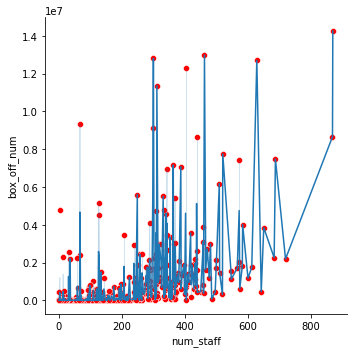

In [271]:
plt.figure(figsize = (30,20))
sns.relplot(x="num_staff", y="box_off_num", data = df_train, color='r',)
sns.lineplot(x="num_staff", y="box_off_num", data = df_train)
plt.show()

### 2.11 num_actor

In [272]:
df_train['num_actor'].unique()

array([ 2,  3,  4,  9,  1,  5,  7,  6,  8, 10, 16, 11, 25,  0, 13, 14, 22])

## 상관계수 확인

In [273]:
df_train.corr().iloc[:-1]

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dist_num_rank,genre_rank,scre_num_rank,scre_nm_rank
time,1.000000,0.266065,0.306727,0.623205,0.114153,0.441452,0.523461,0.404035,0.240933,0.204273
dir_prev_bfnum,0.266065,1.000000,0.396616,0.369657,0.042491,0.293791,0.235885,0.174314,0.100996,0.095578
dir_prev_num,0.306727,0.396616,1.000000,0.450706,0.014006,0.259674,0.359163,0.236391,0.199170,0.185063
num_staff,0.623205,0.369657,0.450706,1.000000,0.077871,0.544265,0.647542,0.466936,0.250536,0.234017
num_actor,0.114153,0.042491,0.014006,0.077871,1.000000,0.111179,0.085962,0.058944,0.065989,0.067075
box_off_num,0.441452,0.293791,0.259674,0.544265,0.111179,1.000000,0.409919,0.279454,0.214533,0.217651
dist_num_rank,0.523461,0.235885,0.359163,0.647542,0.085962,0.409919,1.000000,0.294501,0.261426,0.270930
genre_rank,0.404035,0.174314,0.236391,0.466936,0.058944,0.279454,0.294501,1.000000,0.197025,0.053331
scre_num_rank,0.240933,0.100996,0.199170,0.250536,0.065989,0.214533,0.261426,0.197025,1.000000,0.867382


In [274]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            600 non-null    int64  
 1   dir_prev_bfnum  600 non-null    float64
 2   dir_prev_num    600 non-null    int64  
 3   num_staff       600 non-null    int64  
 4   num_actor       600 non-null    int64  
 5   box_off_num     600 non-null    int64  
 6   dist_num_rank   600 non-null    int64  
 7   genre_rank      600 non-null    int64  
 8   scre_num_rank   600 non-null    float64
 9   scre_nm_rank    600 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 67.7 KB


In [275]:
df_test

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,dist_num_rank,genre_rank,scre_num_rank,scre_nm_rank
0,125,300529.000000,2,304,3,128.0,12,3008.5,1
1,100,0.000000,0,117,5,0.0,8,3008.5,1
2,85,0.000000,0,109,4,55.0,12,3008.5,1
3,115,240459.666667,3,219,4,39.0,7,3008.5,1
4,110,0.000000,0,11,3,0.0,8,3008.5,1
...,...,...,...,...,...,...,...,...,...
238,60,0.000000,0,0,6,111.0,4,8325.0,2
239,106,0.000000,0,0,1,70.0,2,8325.0,2
240,87,0.000000,0,64,3,113.0,2,8325.0,2
241,2015,0.000000,0,4,5,111.0,4,8325.0,2


In [276]:
df_train

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dist_num_rank,genre_rank,scre_num_rank,scre_nm_rank
0,96,0.0,0,91,2,23398,130,11,3008.5,1
1,130,1161602.5,2,387,3,7072501,141,12,3008.5,1
2,96,739522.0,3,342,2,1110523,141,11,3008.5,1
3,89,0.0,0,0,4,745,28,5,3008.5,1
4,107,534232.5,2,15,4,23052,104,3,3008.5,1
...,...,...,...,...,...,...,...,...,...,...
595,94,0.0,0,158,2,3436,74,5,19323.0,3
596,112,385977.5,2,245,8,978413,130,9,19323.0,3
597,78,0.0,0,17,7,172,12,8,19323.0,3
598,108,0.0,0,8,1,2972,70,2,19323.0,3


# 3.**이상치 제거**

In [277]:
#plt.figure(figsize = (15,10))
#sns.boxplot(data=df_train)
#plt.xticks(rotation = 45)

In [278]:
#q3 = df_train['dir_prev_bfnum'].quantile(0.75) # df['국어'].quantile(0.75) 처럼 특정 열만 적용 가능
#q1 = df_train['dir_prev_bfnum'].quantile(0.25)

#iqr = q3 - q1

In [279]:
# 'dir_prev_bfnum' 열에 대하여 이상치 여부를 판별해주는 함수
#def is_kor_outlier(df_train):
#    dir_prev_num = df_train['dir_prev_bfnum']
#    if dir_prev_num > q3 + 1.5 * iqr or dir_prev_num < q1 - 1.5 * iqr:
#        return True
#    else:
#        return False

# apply 함수를 통하여 각 값의 이상치 여부를 찾고 새로운 열에 결과 저장
#df_train['dir_prev_bfnum_이상치여부'] = df_train.apply(is_kor_outlier, axis = 1) # axis = 1 지정 필수

In [280]:
#df_train.head(10)

In [281]:
# 이상치인 행은 제거하여 필터링
#df_train = df_train.loc[df_train['dir_prev_bfnum_이상치여부'] == False]

# 이상치여부를 나타내는 열 제거
#del df_train['dir_prev_bfnum_이상치여부']

#df_train 

In [282]:
#plt.figure(figsize = (15,10))
#sns.boxplot(data=df_train)
#plt.xticks(rotation = 45)

In [283]:
df_train


,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dist_num_rank,genre_rank,scre_num_rank,scre_nm_rank
0,96,0.0,0,91,2,23398,130,11,3008.5,1
1,130,1161602.5,2,387,3,7072501,141,12,3008.5,1
2,96,739522.0,3,342,2,1110523,141,11,3008.5,1
3,89,0.0,0,0,4,745,28,5,3008.5,1
4,107,534232.5,2,15,4,23052,104,3,3008.5,1
...,...,...,...,...,...,...,...,...,...,...
595,94,0.0,0,158,2,3436,74,5,19323.0,3
596,112,385977.5,2,245,8,978413,130,9,19323.0,3
597,78,0.0,0,17,7,172,12,8,19323.0,3
598,108,0.0,0,8,1,2972,70,2,19323.0,3


# 4.**학습&예측**

훈련데이터 테스트데이터 나누기

In [284]:
X = df_train[['time',	'dir_prev_bfnum',	'dir_prev_num',	'num_staff',
              'dist_num_rank',	'genre_rank',	'scre_num_rank',	'scre_nm_rank']]
y = np.log1p(df_train.box_off_num)

In [285]:
target = df_test[['time',	'dir_prev_bfnum',	'dir_prev_num',	'num_staff',
              'dist_num_rank',	'genre_rank',	'scre_num_rank',	'scre_nm_rank']]

5Fold 교차검증

In [207]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 111 kB/s 


In [286]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
        

In [287]:
kf = KFold(n_splits =  5, shuffle = True, random_state = 42)

### 5가지 모델 사용
#### 1) GradientBoostingRegressor

In [288]:
gbm = GradientBoostingRegressor(random_state = 42)

In [289]:
rmse_list = []
gb_pred = np.zeros((df_test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in gbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in gbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    gb_pred += (sub_pred / 10)

In [290]:
np.mean(rmse_list)

1054283.2448083924

#### 2) LGBMRegressor

In [291]:
lgbm = LGBMRegressor(random_state = 42)

In [292]:
rmse_list = []
lgb_pred = np.zeros((df_test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    lgb_pred += (sub_pred / 10)

In [293]:
np.mean(rmse_list)

1203803.1428036501

#### 4) XGBRegressor

In [294]:
xgb = XGBRegressor(random_state = 42)

In [295]:
rmse_list = []
xgb_pred = np.zeros((df_test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    xgb_pred += (sub_pred / 10)

[00:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [296]:
np.mean(rmse_list)

1116964.6853792064

#### 5) CatBoostRegressor

In [297]:
cat = CatBoostRegressor(random_state = 42, silent = True)

In [298]:
rmse_list = []
cat_pred = np.zeros((df_test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    cat.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in cat.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in cat.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    cat_pred += (sub_pred / 10)

In [299]:
np.mean(rmse_list)

1066620.6134897817

#### 6) RandomForestRegressor

In [300]:
rf = RandomForestRegressor(random_state = 42)

In [301]:
rmse_list = []
rf_pred = np.zeros((df_test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    rf.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    rf_pred += (sub_pred / 10)

In [302]:
np.mean(rmse_list)

893053.4981180755

***

#### 최종 예측 결과 블렌딩

In [303]:
df_sub

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0
...,...,...
238,해에게서 소년에게,0
239,울보 권투부,0
240,어떤살인,0
241,말하지 못한 비밀,0


In [304]:
df_train.shape

(600, 10)

In [305]:
(xgb_pred + cat_pred + lgb_pred + rf_pred + gb_pred ) / 5

array([9.21256081e+05, 2.25210784e+01, 9.90073925e+02, 6.84527395e+03,
       4.04269151e+01, 4.86159323e+03, 3.61221726e+05, 1.90129046e+03,
       1.45647920e+03, 1.72324813e+01, 7.68786444e+04, 3.61531668e+05,
       1.34604421e+03, 1.79263781e+02, 2.22960431e+05, 2.17481002e+01,
       8.62211549e+03, 6.40156933e+01, 3.04397758e+05, 1.35537946e+02,
       2.78960761e+02, 1.69742905e+06, 1.66413036e+03, 7.52180157e+02,
       5.21498484e+05, 6.19637988e+04, 5.75663034e+05, 3.32943993e+03,
       1.38024957e+04, 1.48531796e+06, 5.46135875e+02, 7.92232632e+05,
       2.28035491e+03, 2.65954604e+05, 4.49708496e+03, 2.16664104e+04,
       1.50520700e+05, 2.99154857e+01, 1.89935970e+02, 2.53189635e+02,
       1.32695877e+01, 1.90717547e+02, 1.05358621e+02, 2.05447173e+02,
       2.15005353e+01, 4.33793933e+01, 8.60442433e+02, 9.66179075e+02,
       3.30010458e+01, 3.43335586e+03, 2.45588568e+02, 1.82600084e+03,
       1.09621392e+06, 1.18255295e+06, 1.29134704e+04, 3.58929021e+02,
      

In [306]:
df_sub['box_off_num'] = rf_pred 

In [307]:
df_sub.sort_values(by = 'box_off_num')

,title,box_off_num
40,량강도 아이들,6.445278e+00
37,하얀 정글,6.736026e+00
15,포화 속으로,6.946174e+00
88,한경직,7.015390e+00
48,도가니,7.021404e+00
...,...,...
157,스퀴시랜드,1.820531e+06
190,"제자, 옥한흠",2.072129e+06
182,숙희,2.122204e+06
183,더 테너 리리코 스핀토,2.254792e+06


In [308]:
df_sub

,title,box_off_num
0,용서는 없다,777176.031828
1,아빠가 여자를 좋아해,7.188665
2,하모니,1301.449534
3,의형제,4606.207206
4,평행 이론,7.135810
...,...,...
238,해에게서 소년에게,21335.049294
239,울보 권투부,3307.254594
240,어떤살인,25968.403567
241,말하지 못한 비밀,10460.819964


In [310]:
df_sub.to_csv("df_submission4.csv", index = False)